In [12]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

In [13]:
import warnings
import pickle
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from oracle import make_oracle
from optimize import optimize_newton, optimize_gd, optimize_hfn

from sklearn.linear_model import LogisticRegression

warnings.filterwarnings('ignore')
np.random.seed(42)

In [23]:
def plot_model(oracle, optimizers_param):
    model = LogisticRegression(penalty="none", tol=1e-8, max_iter=10000, n_jobs=-1, fit_intercept=False)
    model.fit(oracle.X, oracle.y.ravel())
    
    entropy_true = oracle.value(model.coef_.reshape(-1, 1))
    
    w_n = oracle.X.shape[1]
    w_init = np.zeros((w_n, 1))
    
    fig, axs = plt.subplots(3, 1, figsize=(10, 35)) # 12, 18
    
    for i, (name, log_feature, optimizer, line_search_methods) in enumerate(optimizers_param):
        for line_search in line_search_methods:        
            w, log = optimizer(oracle, w_init, line_search_method=line_search)
            
            if log_feature == "n_iters":
                feature = np.arange(log.get_log()["time"].shape[0])
            else:
                feature = log.get_log()[log_feature]
            
            entropy = log.get_log()["entropy"]

            axs[i].plot(feature, np.log(np.abs(entropy - entropy_true)), 
                        label=f"{line_search}: {np.round(np.min(entropy), 4)}")
    
    for ax, param in zip(axs.flat, optimizers_param):
        ax.set_title(param[0])
        ax.set(xlabel=f"{log_feature}", ylabel="absolute error")
        ax.legend()

# a1a dataset

In [24]:
a1a_oracle = make_oracle("data/a1a.txt")

# TODO: function to generate data once into json/pickle and dump -> then graphs
a1a_optim_params = [[
    ("gradien descent", x_axis, optimize_gd, ["golden", "brent", "armijo", "wolfe", "lipschitz"]),
    ("newton", x_axis, optimize_newton, ["golden", "brent", "armijo", "wolfe"]),
    ("hessian-free newton", x_axis, optimize_hfn, ["golden", "brent", "armijo", "wolfe"])
] for x_axis in ["n_iters", "time", "call_count"]]

### Number of iterations

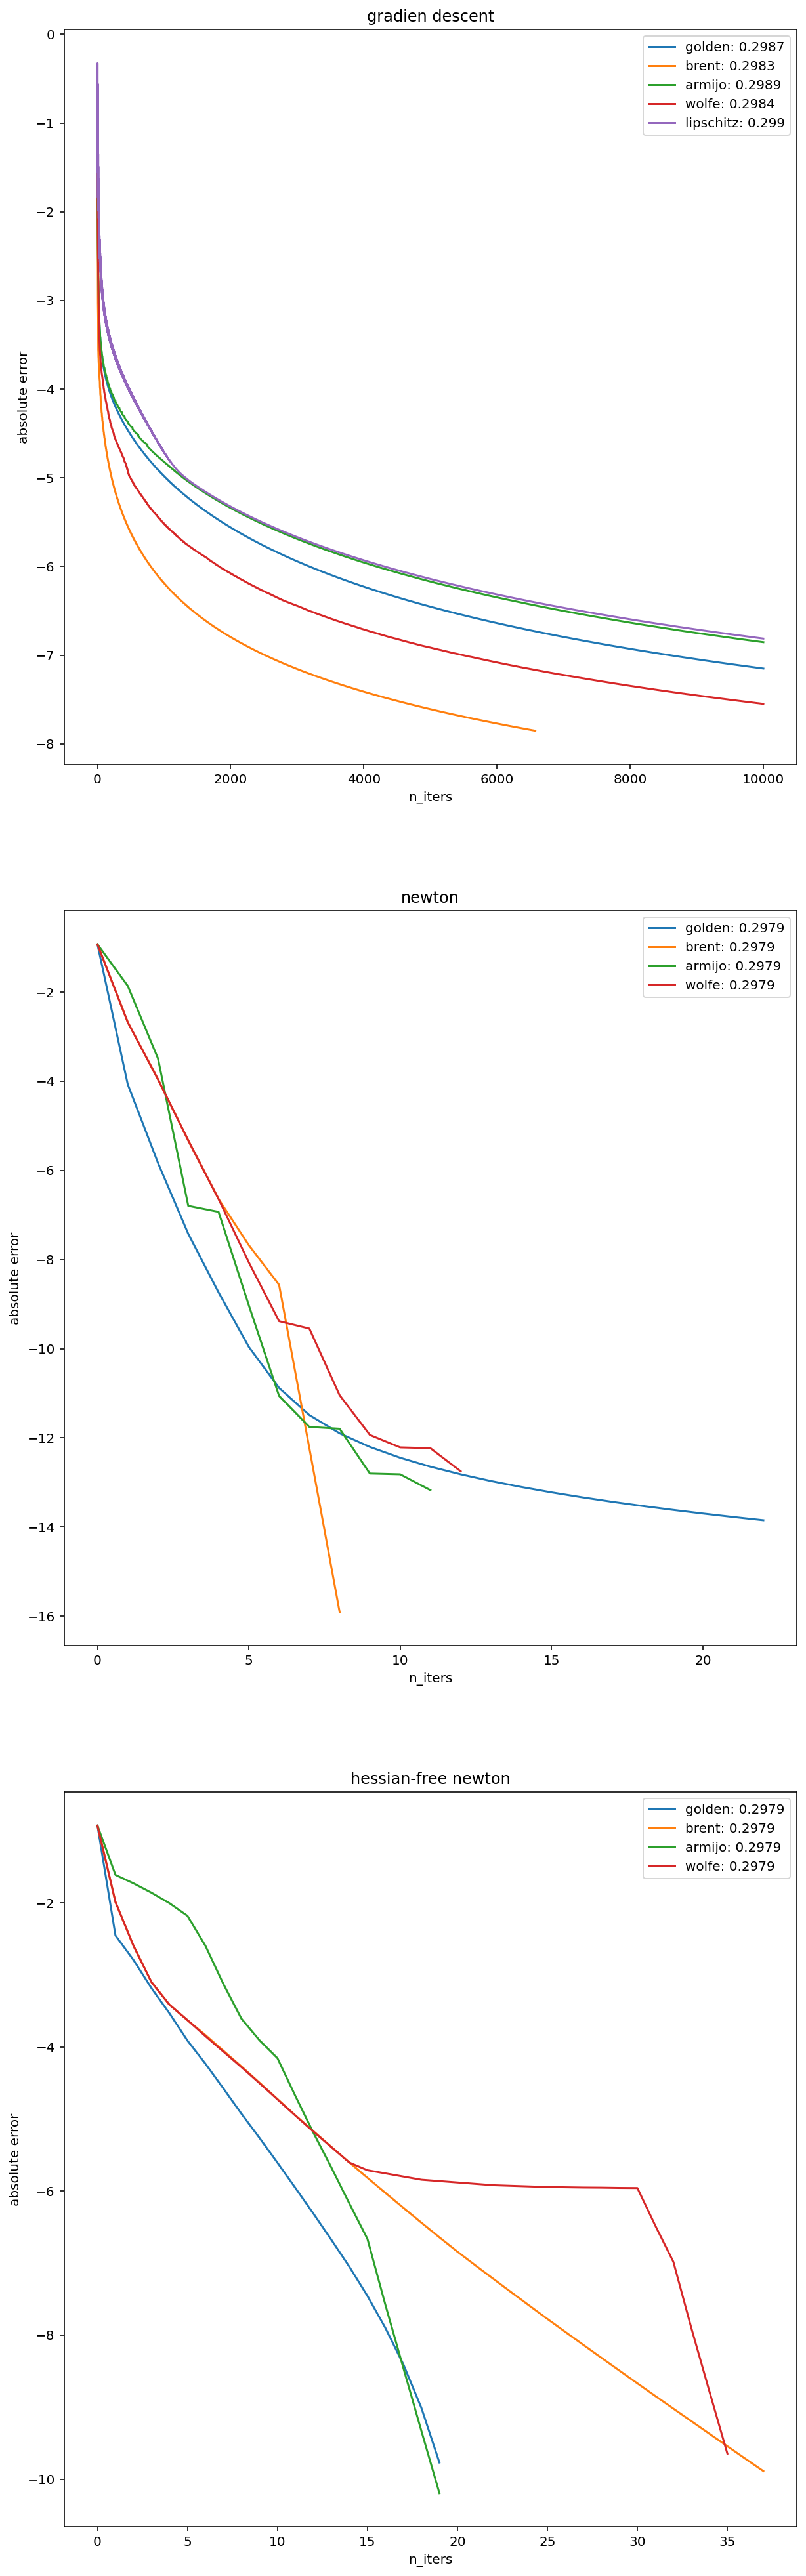

In [25]:
plot_model(a1a_oracle, a1a_optim_params[0])

### Time

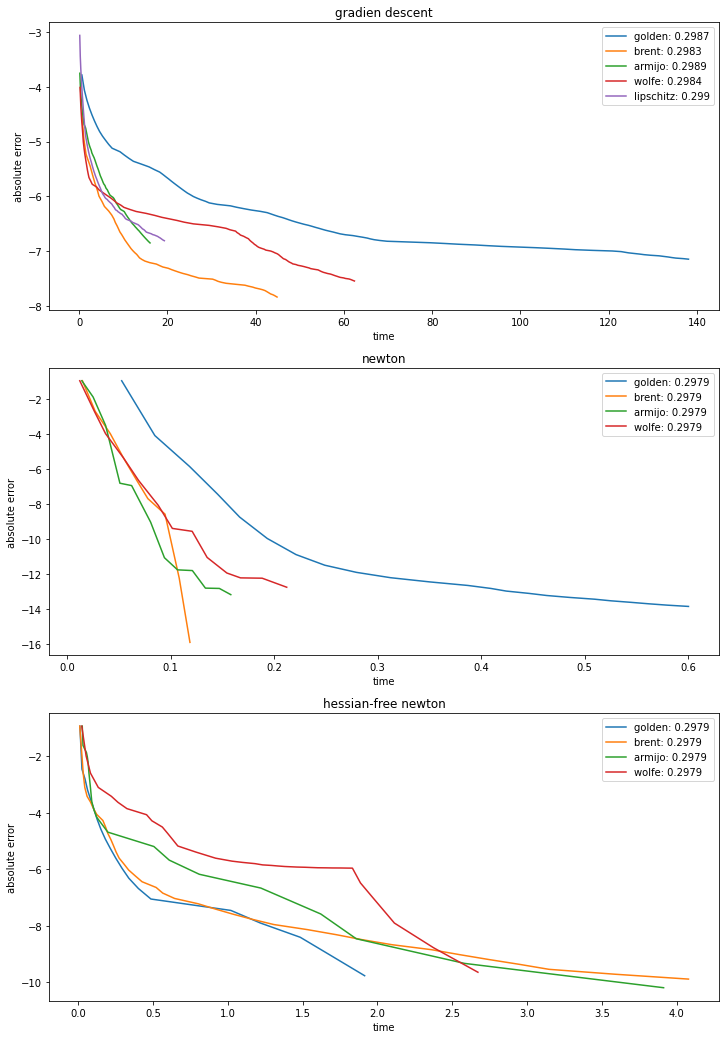

In [6]:
plot_model(a1a_oracle, a1a_optim_params[1])

### Number of oracle calls

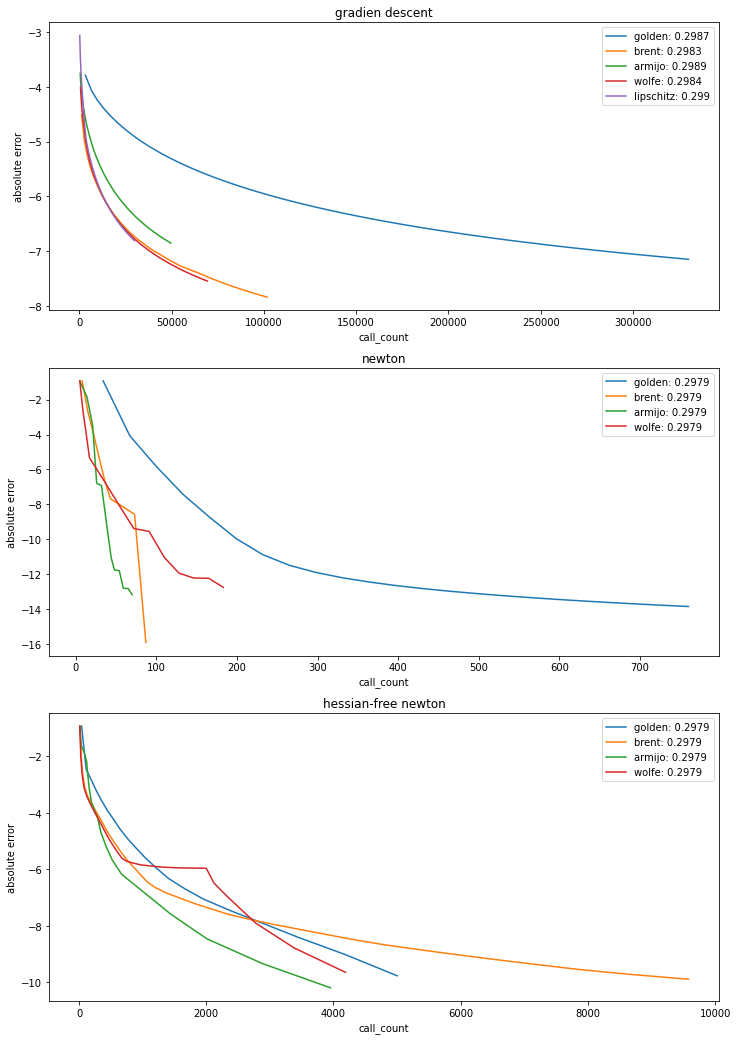

In [7]:
plot_model(a1a_oracle, a1a_optim_params[2])

In [2]:
with open("optimize_data/line_search_data.pkl", "rb") as log_file:
    log = pickle.load(log_file)